In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from IPython.display import display, clear_output
import logging

# PyTorch Lightning
import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger

# Calvera bandit library
from calvera.bandits import NeuralUCBBandit
from calvera.utils import TopKSelector, InMemoryDataBuffer, AllDataBufferStrategy
from calvera.benchmark import BanditBenchmarkEnvironment, OnlineBanditLoggerDecorator
from calvera.benchmark.datasets import SyntheticCombinatorialDataset

In [2]:
class Network(nn.Module):
    """Neural network with one hidden layer and ReLU activation."""

    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))


Context shape: torch.Size([20, 80])
Reward shape: torch.Size([20])

Rewards: [0.0009425383759662509, 0.01591693051159382, 0.0020510931499302387, 0.010034953244030476, 3.051970270462334e-05, 0.005022116005420685, 0.007191677577793598, 0.0016485119704157114, 0.006944944150745869, 0.01584775559604168, 0.029920300468802452, 2.3011356461211108e-05, 0.0015777185326442122, 0.029857859015464783, 0.0005690084653906524, 0.00090129638556391, 9.238207894668449e-06, 0.003150854492560029, 2.8514810765045695e-05, 0.020021598786115646]

Top 4 arms: [10, 13, 19, 1]
Top 4 rewards: [0.029920300468802452, 0.029857859015464783, 0.020021598786115646, 0.01591693051159382]


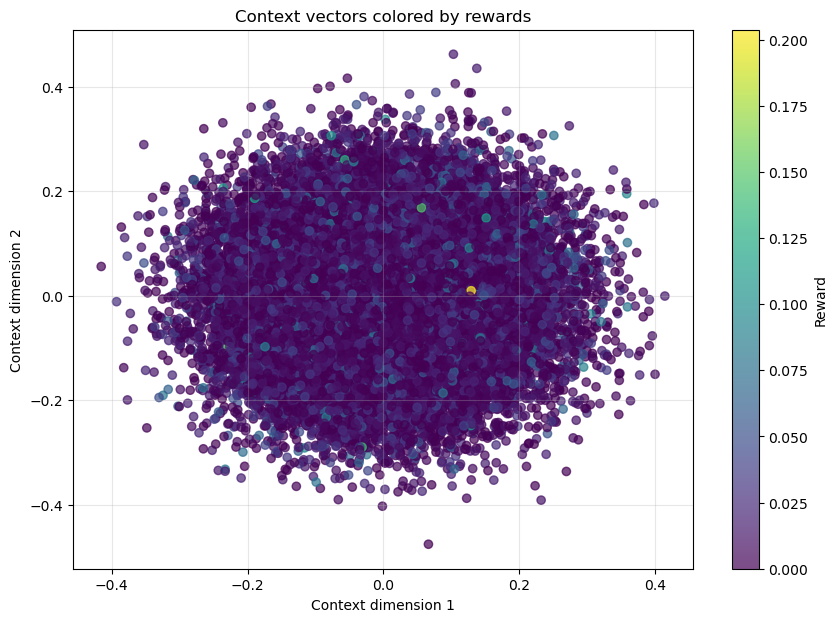

In [3]:
# Create a synthetic dataset for combinatorial bandits
dataset = SyntheticCombinatorialDataset(
    n_samples=2000,
    num_actions=20,  # Total number of possible actions
    context_size=80,  # Dimension of context features
    function_type="quadratic",
    seed=42,
)

# Examine a single example
contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

# Check the top-K arms for this example
K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

# Visualize the first two dimensions of the context features
plt.figure(figsize=(10, 7))
plt.scatter(
    dataset.contexts.view(-1, dataset.context_size)[:, 0],
    dataset.contexts.view(-1, dataset.context_size)[:, 1],
    c=dataset.rewards.view(-1, dataset.context_size)[:],
    cmap="viridis",
    alpha=0.7,
)
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")
plt.grid(alpha=0.3)
plt.show()

In [4]:
# Configuration
K = 4  # Number of items to select
BATCH_SIZE = 100
NUM_SAMPLES = 2000
HIDDEN_SIZE = 100

# Create data loader with a subset of the data
train_loader = DataLoader(Subset(dataset, range(NUM_SAMPLES)), batch_size=BATCH_SIZE, shuffle=True)

# Initialize the bandit environment
env = BanditBenchmarkEnvironment(train_loader)

# Create memory buffer to store experiences
buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=None,  # Store all experiences
)

# Initialize neural network
network = Network(dataset.context_size, hidden_size=HIDDEN_SIZE)

# Initialize the NeuralUCBBandit module with TopKSelector
bandit_module = NeuralUCBBandit(
    n_features=dataset.context_size,
    network=network,
    selector=TopKSelector(k=K),  # Select top K arms
    buffer=buffer,
    train_batch_size=BATCH_SIZE,
    early_stop_threshold=1e-4,
    weight_decay=1e-4,
    exploration_rate=1,
    learning_rate=1e-2,
    min_samples_required_for_training=1,
    initial_train_steps=0,
)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.abstract_bandit").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.neural_bandit").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger("logs", name="combinatorial_neural_ucb_bandit", flush_logs_every_n_steps=100),
    enable_console_logging=False,
)

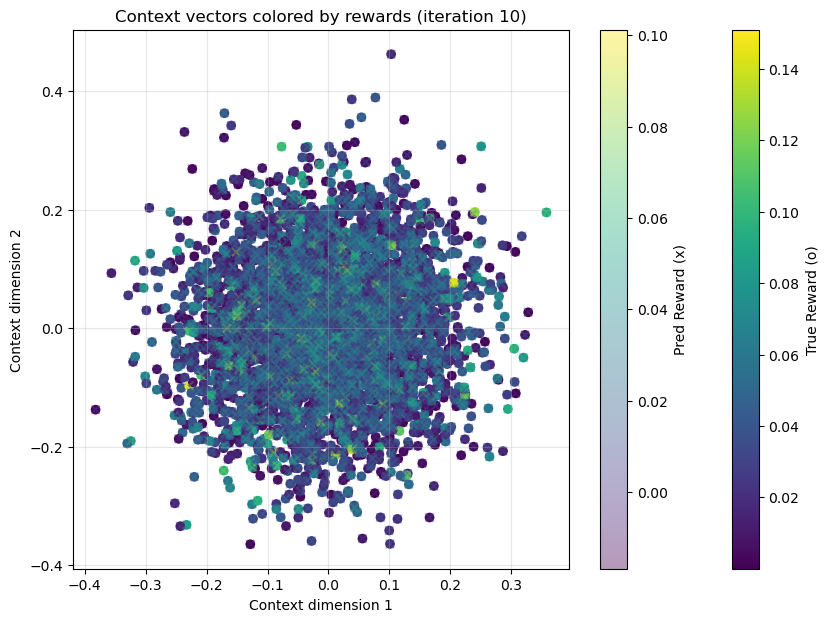

Training Combinatorial Neural UCB bandit: 100%|██████████| 20/20 [01:16<00:00,  3.83s/it, acc_regret=56.4, avg_regret=0.0282, regret=0.00388, reward=0.134]


,reward,regret
0,0.047381,0.127239
1,0.024078,0.090987
2,0.078658,0.088864
3,0.064354,0.025278
4,0.017684,0.114577


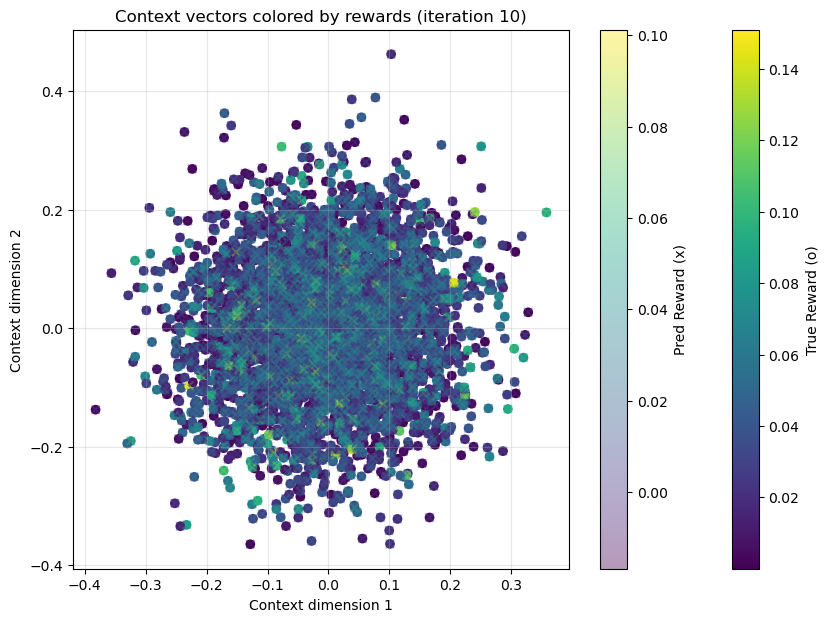

In [5]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Set up visualization
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter([], [], c=[], cmap="viridis")
cbar = fig.colorbar(scatter, ax=ax, label="True Reward (o)")
cbar2 = fig.colorbar(scatter, ax=ax, label="Pred Reward (x)")

# Training loop with progress bar
progress_bar = tqdm(enumerate(env), total=len(env), desc="Training Combinatorial Neural UCB bandit")

for i, contextualized_actions in progress_bar:
    # 1. Select actions based on current model
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # 2. Set up trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=1000,
        logger=logger,
        gradient_clip_val=5.0,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
    )

    # 3. Get feedback and compute regret
    chosen_contextualized_actions, realized_scores = env.get_feedback(chosen_actions)
    realized_rewards = realized_scores.sum(dim=1)  # Sum rewards across selected items
    batch_regret = env.compute_regret(chosen_actions)

    # 4. Record metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # 5. Update progress bar with current metrics
    progress_bar.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
        acc_regret=np.sum(regrets),
    )

    # 6. Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_scores)
    trainer.fit(bandit_module)

    # 7. Get model predictions for visualization
    pred_y = bandit_module.theta_t(buffer.contextualized_actions).detach().numpy()

    # 8. Visualize learning progress every 10 iterations
    if i % 10 == 0:
        ax.clear()

        # Plot true rewards
        scatter_true = ax.scatter(
            buffer.contextualized_actions[:, 0, 0],
            buffer.contextualized_actions[:, 0, 1],
            c=buffer.rewards,
            cmap="viridis",
            marker="o",
            label="True Rewards",
            alpha=1.0,
        )

        # Plot predicted rewards
        scatter_pred = ax.scatter(
            buffer.contextualized_actions[:, 0, 0],
            bandit_module.buffer.contextualized_actions[:, 0, 1],
            c=pred_y,
            marker="x",
            cmap="viridis",
            alpha=0.4,
        )

        # Set up plot labels
        ax.set_xlabel("Context dimension 1")
        ax.set_ylabel("Context dimension 2")
        ax.set_title(f"Context vectors colored by rewards (iteration {i})")
        ax.grid(alpha=0.3)

        # Update colorbars
        cbar.update_normal(scatter_true)
        cbar2.update_normal(scatter_pred)

        # Show the updated plot
        clear_output(wait=True)
        display(fig)

# Store metrics in a DataFrame
metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

# Display the first few rows of metrics
metrics.head()

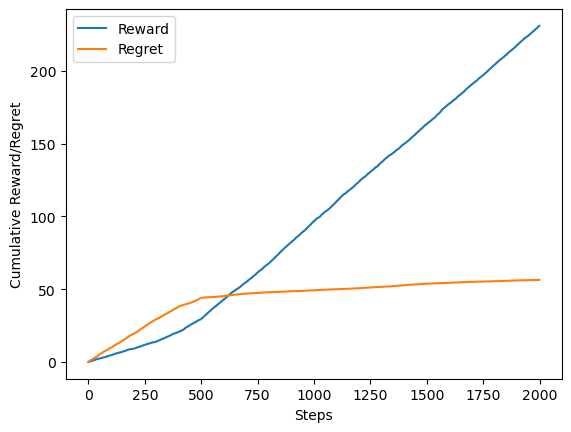

In [6]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [7]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.0415
Average reward (first 100 rounds): 0.0465
Average reward (all rounds): 0.1154

Average regret (first 10 rounds): 0.1089
Average regret (first 100 rounds): 0.0971
Average regret (all rounds): 0.0282


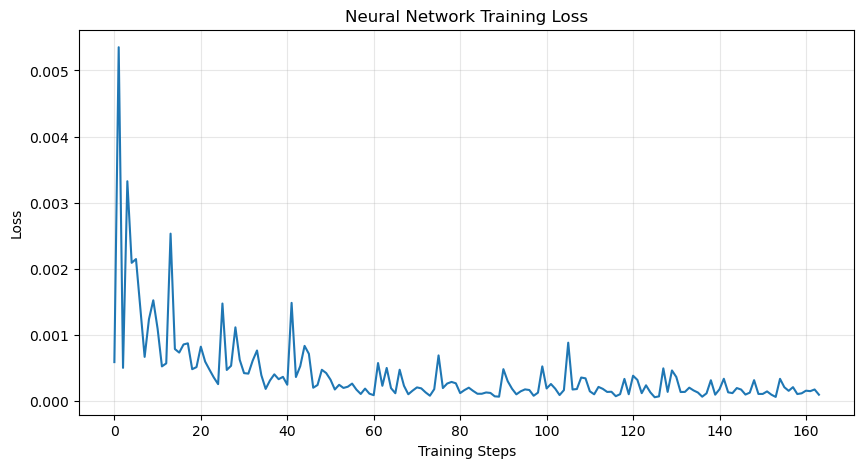

In [8]:
# Load the training metrics
bandit_metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
bandit_metrics = pd.read_csv(bandit_metrics_csv)

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(bandit_metrics["loss"])
plt.title("Neural Network Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.show()